<a href="https://colab.research.google.com/github/ChenTaHung/Business-Data-Analytics/blob/master/Business_Data_Analytics_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install datatable

In [0]:
import pandas as pd
import numpy as np
import datatable as dt

### Import Data from Google Drive (personal account)

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
Data = dt.fread("drive/My Drive/Data_For_Model.csv").to_pandas()

### Check Histogram Before and After Dropna




In [0]:
# print(Data.shape) # (2402909, 36)
# print(Data.dropna().shape) # (1669220, 36)

In [0]:
Data_dropna["LuckyOrNot"].value_counts()
# UnLucky    1588699
# Lucky        80521

UnLucky    1588699
Lucky        80521
Name: LuckyOrNot, dtype: int64

In [0]:
import matplotlib.pyplot as plt
plotsize = plt.figure(figsize = (15, 20))
ax = plotsize.gca()  
# Data before dropping NaN
Data.hist(ax = ax)

In [0]:
plotsize = plt.figure(figsize = (15, 20))
ax = plotsize.gca()  
# print("Data after dropping NaN")
Data.dropna().hist(ax = ax)

> **_Except Age_of_Driver has a little change, but I think the difference is not serious since the age that lower than 20 is not even able to drive a car_**

### Drop Missing Value

In [0]:
# Since the data is adequate, we decided to remove all the row that contains NaN
Data_dropna = Data.dropna()

### Convert Dummy Variables

In [0]:
# Get Dummy Variables
DummyCols = Data.dtypes.index[np.where((Data.dtypes == "object") & (Data.dtypes.index != "LuckyOrNot"))]
Population = pd.get_dummies(data = Data_dropna, columns = DummyCols,dtype = np.int16)
Population.head()
del DummyCols

### Model Sampling

In [0]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Since the Response proportion has a huge gap between two labels
# We use Under-sampling (prototype selection)
def Undersampling(data, label) :
  Train = data
  lev1 = Train[label].value_counts().index[0]
  lev2 = Train[label].value_counts().index[1]
  val1 = Train[label].value_counts().values[0]
  val2 = Train[label].value_counts().values[1]

  if val1 > val2 :
    largerSample = lev1
    smallerSample = lev2
    del lev1, lev2
  else :
    largerSample = lev2
    smallerSample = lev1
    del lev1, lev2
  
  LargeSampleData = Train[Train[label] == largerSample]
  SmallSampleData = Train[Train[label] == smallerSample]

  ExtractNrow = SmallSampleData.shape[0]
  subsampleIndex = np.random.randint(0, LargeSampleData.shape[0]-1,ExtractNrow)

  Chosen_LargeSample = LargeSampleData.iloc[subsampleIndex,:]
  Under_Sample_SubSample = pd.concat([SmallSampleData, Chosen_LargeSample], axis = 0)

  return Under_Sample_SubSample
# Function End

### Random Forest in XGB


In [0]:
import xgboost as xgb

In [0]:
UnderSample_population = Undersampling(data = Population, label = "LuckyOrNot")

# Create Train Test Data with constant response term proportion
trainX, testX, trainY, testY = train_test_split(UnderSample_population.iloc[:, 1:], 
                                                UnderSample_population.iloc[:, 0], 
                                                shuffle = True, 
                                                stratify = UnderSample_population.iloc[:, 0],
                                                train_size = 0.7)
# Sampling End



In [0]:
# Turn Y into {1,0}
LabeledtrainY = Lencoder.transform(trainY)
train_DMatrix = xgb.DMatrix(trainX, LabeledtrainY)

In [0]:
### Train RF with xgboost package
params = {
  'colsample_bynode': 0.5,
  'learning_rate': 0.01,
  'max_depth': 15,
  'num_parallel_tree': 250,
  'objective': 'binary:logistic',
  'subsample': 0.7,
  'tree_method': 'gpu_hist'
}

XGB_RF = xgb.train(params, train_DMatrix, num_boost_round = 1)

In [0]:
Lev1_prob = XGB_RF.predict(xgb.DMatrix(testX))
Res = Lencoder.inverse_transform(np.where(Lev1_prob >=0.5, 1, 0))

In [0]:
# Validate Model
def Scores(true_y, pred_y_prob) :
  Lencoder = LabelEncoder().fit(true_y.value_counts().index)

  trueY_Label = true_y
  trueY_Encode = Lencoder.transform(true_y)
  pred_y_prob = pred_y_prob
  pred_y_Encode = np.where(pred_y_prob >= 0.5, 1, 0)
  pred_y_Label = Lencoder.inverse_transform(pred_y_Encode)

  print("Accuracy : ", metrics.accuracy_score(trueY_Encode, pred_y_Encode))
  print("Recall : ", metrics.recall_score(trueY_Encode, pred_y_Encode))
  print("Precision : ", metrics.precision_score(trueY_Encode, pred_y_Encode))
  print("f1-score : ", metrics.f1_score(trueY_Encode, pred_y_Encode))
  print("Auc :", metrics.roc_auc_score(trueY_Encode, pred_y_prob))

Scores(testY, Lev1_prob)

Accuracy :  0.7256225032599921
Recall :  0.689973505547276
Precision :  0.7429348310599982
f1-score :  0.7154754239107104
Auc : 0.8029487442920706


In [0]:
import matplotlib.pyplot as plt

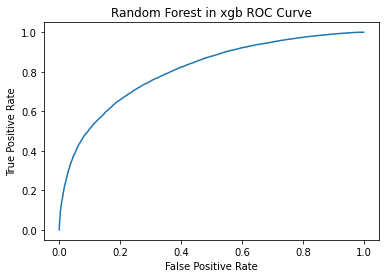

In [0]:
# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(Lencoder.transform(testY), Lev1_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest in xgb ROC Curve")
plt.show()

### CatBoost Classifier (No Need Dummy)


In [0]:
!pip install CatBoost

In [0]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

In [0]:
# UnderSampling for Catboost
Data_dropna_underS = Undersampling(Data_dropna, "LuckyOrNot")
Data_dropna_underS.loc[:, "LuckyOrNot"] = np.where(Data_dropna_underS["LuckyOrNot"] == "Lucky", 1, 0)
# End

# Create Train Test Data with constant response term proportion
catrainX, catestX, catrainY, catestY = train_test_split(Data_dropna_underS.loc[:,Data_dropna.columns != 'LuckyOrNot'], 
                                                        Data_dropna_underS.iloc[:, 27], 
                                                        shuffle = True, 
                                                        stratify = Data_dropna_underS.iloc[:, 27],
                                                        train_size = 0.7)
# End

In [0]:
# Create Pool train test data for catboost
categorical_features_indices = np.where(catrainX.dtypes != np.float)[0]
train_pool = Pool(catrainX, catrainY, cat_features=categorical_features_indices)
test_pool = Pool(catestX, cat_features=categorical_features_indices)
# End

In [0]:
# Fit the Model!
catboost_model = CatBoostClassifier(iterations=1000, 
                                    loss_function = "Logloss",
                                    custom_metric = "AUC",
                                    learning_rate = 0.1,
                                    bootstrap_type = "Bayesian",
                                    depth = 7,
                                    min_data_in_leaf = 1, 
                                    task_type = "GPU",
                                    silent = True)

catboost_model.fit(train_pool)

In [0]:
# Predict
cat_pred_label = catboost_model.predict(test_pool, prediction_type="Class")
cat_pred_prob = catboost_model.predict(test_pool, prediction_type="Probability")
catboost_res_DF = pd.DataFrame(cat_pred_prob, columns=[0, 1]).assign(Label = cat_pred_label)

In [0]:
catboost_res_DF

,0,1,Label
0,0.189127,0.810873,1
1,0.841196,0.158804,0
2,0.410583,0.589417,1
3,0.916351,0.083649,0
4,0.735294,0.264706,0
...,...,...,...
48308,0.234711,0.765289,1
48309,0.550757,0.449243,0
48310,0.900294,0.099706,0
48311,0.589639,0.410361,0


Accuracy: 0.7278372280752593
AUC:  0.8056517740453497
Recall: 0.7702943246264022
Precision: 0.71001221001221
f1 Score: 0.738925841358086


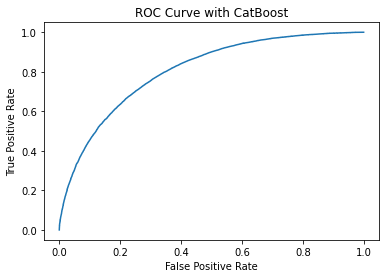

In [0]:
# Score
def Cat_boost_model_Score(estimator) :
  # Accuracy
  print("Accuracy:",estimator.score(X = catestX, y = catestY))
  # AUC
  fpr, tpr, thresholds = metrics.roc_curve(catestY , catboost_res_DF[1])
  print("AUC: ", metrics.auc(fpr, tpr))
  # Recall
  print("Recall:", metrics.recall_score(catestY, cat_pred_label))
  # Precision
  print("Precision:", metrics.precision_score(catestY, cat_pred_label))
  # f1-score
  print("f1 Score:",metrics.f1_score(catestY, cat_pred_label, pos_label=1))
  # ROC Curve
  fpr, tpr, thresholds = metrics.roc_curve(catestY, catboost_res_DF[1], pos_label = 1)
  plt.plot(fpr, tpr)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve with CatBoost")
  plt.show()

Cat_boost_model_Score(catboost_model)

# Accuracy: 0.7290170347525511
# AUC:  0.8060161445738684
# Recall: 0.7615913230667329
# Precision: 0.7150019432568986
# f1 Score: 0.7375616405404323

### Variable Importance CatBoost

In [0]:
import matplotlib.pyplot as plt

In [0]:
# FeatureImportance: Equal to PredictionValuesChange for non-ranking metrics and 
# LossFunctionChange for ranking metrics (the value is determined automatically).
VarImp = catboost_model.get_feature_importance(data = train_pool)  # permutation
CatVarImpDF = pd.DataFrame({"Feature" : catrainX.columns, "Importance" : VarImp})

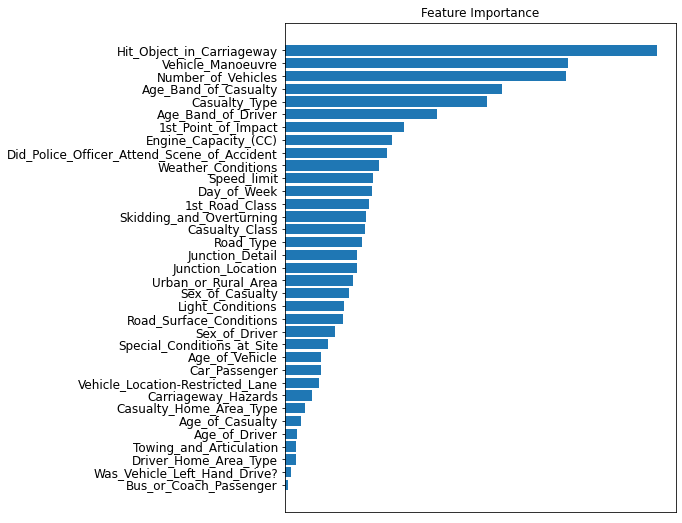

In [0]:
plt.figure(figsize=(7,9))
plt.barh(CatVarImpDF.sort_values(by="Importance")["Feature"], CatVarImpDF.sort_values(by="Importance")["Importance"])
plt.tick_params(labelsize=12)
plt.xticks([])
plt.title("Feature Importance")
plt.show()

### Shap Value Interpretation! (CatBoostClassifier)

In [0]:
!pip install shap

In [0]:
import shap

In [0]:
catestX_Shap = catestX.reset_index().drop("index", axis = 1)
# SHAP Importance
VarImpShap = catboost_model.get_feature_importance(data = train_pool, type="ShapValues")
# Shap Explain
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(catestX_Shap) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


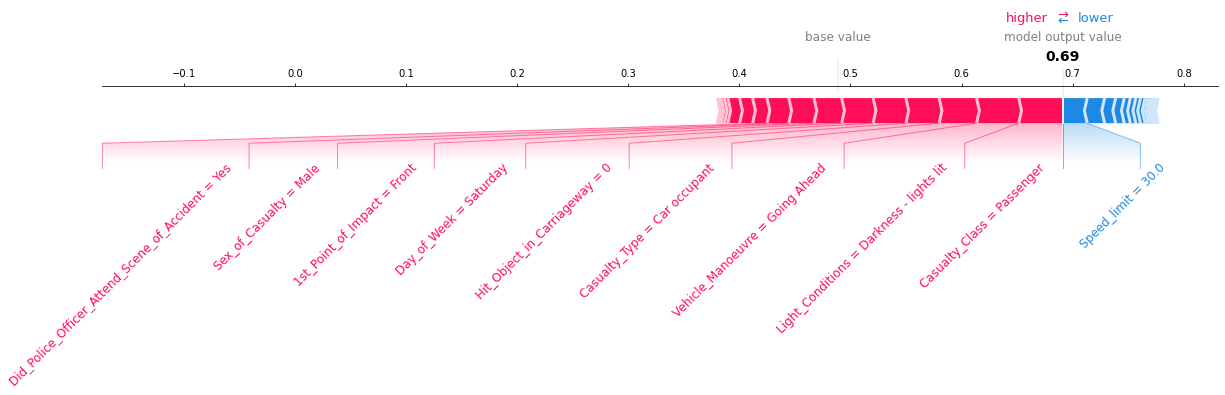

In [0]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[49,:], catestX_Shap.iloc[49,:], text_rotation=45, matplotlib= True, link = "logit")

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], catestX_Shap.iloc[:100,:])

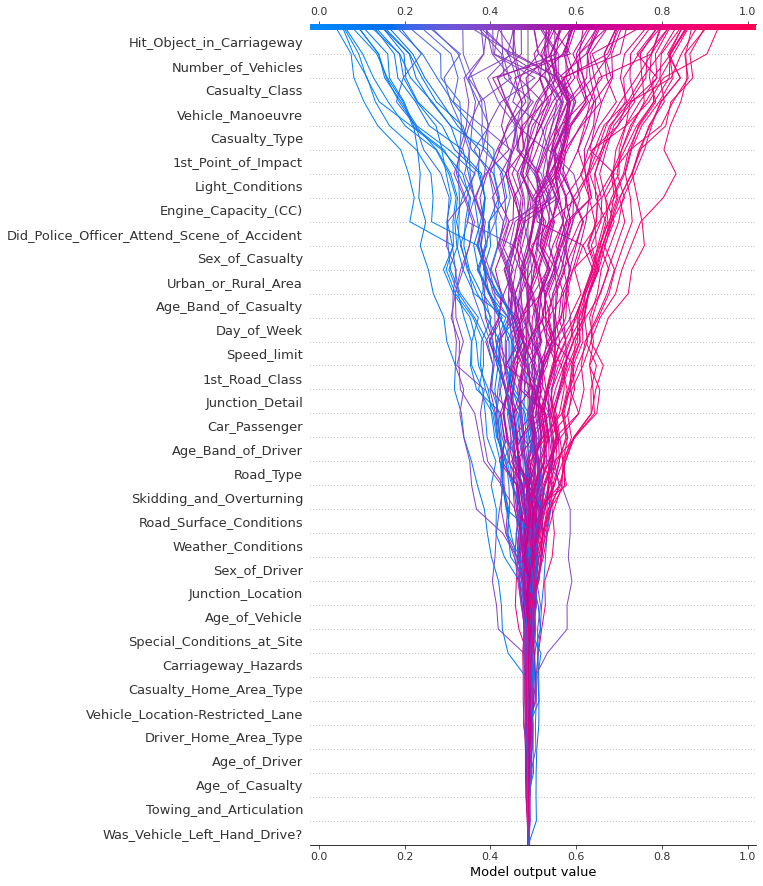

In [0]:
shap.decision_plot(explainer.expected_value, shap_values[:100, :], catestX_Shap.iloc[:100, :],ignore_warnings=True, link = "logit", feature_display_range=range(35, 0, -1) )

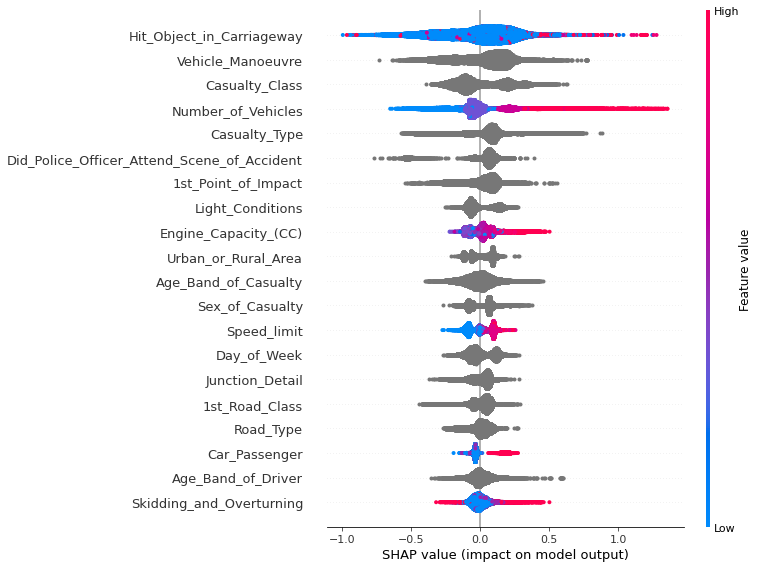

In [0]:
shap.summary_plot(shap_values, catestX_Shap)

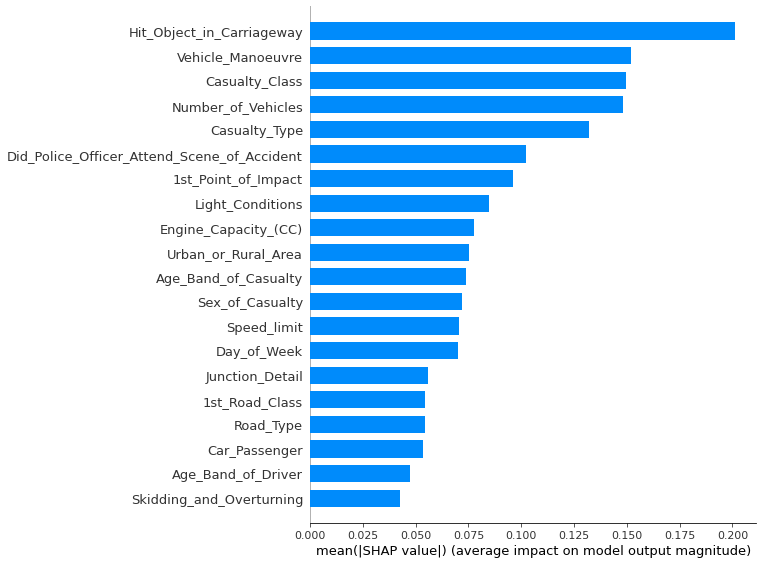

In [0]:
shap.summary_plot(shap_values, catestX, plot_type="bar")

### Grid Search CV Catboost

In [0]:
### GridSearchCV
from sklearn.model_selection import GridSearchCV
parms = {"learning_rate" : [1, 0.5, 0.1],
         "iterations" : [750, 1000, 1250],
         "depth" :[3,5,7]}
catboost_model_grid = CatBoostClassifier(loss_function = "Logloss",
                                         custom_metric = "F1",
                                         task_type = "GPU", 
                                         cat_features = categorical_features_indices,
                                         min_data_in_leaf = 1,
                                         silent = True)
Grid_Catboost = GridSearchCV(estimator = catboost_model_grid, param_grid = parms, cv = 5, n_jobs = 1)
Grid_Catboost.fit(catrainX, catrainY)

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n", Grid_Catboost.best_estimator_)
    
print("\n The best score across ALL searched params:\n", Grid_Catboost.best_score_)
    
print("\n The best parameters across ALL searched params:\n", Grid_Catboost.best_params_)
    
print("\n ========================================================")

# ========================================================
#  Results from Grid Search 
# ========================================================
 
#  The best estimator across ALL searched params:
#  <catboost.core.CatBoostClassifier object at 0x7f46b8d864a8>

#  The best score across ALL searched params:
#  0.7259888825009236

#  The best parameters across ALL searched params:
#  {'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}

#  ========================================================


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7259888825009236

 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 1000, 'learning_rate': 0.1}



In [0]:
# Best Esrimator Fit!
Cat_boost_model_Score(Grid_Catboost.best_estimator_)

# Accuracy: 0.7266781197607269
# AUC:  0.8045542831278494
# Recall: 0.6930910295152544
# Precision: 0.7430105618176978
# f1 Score: 0.735556223090017

Accuracy: 0.7266781197607269
AUC:  0.8045542831278494
Recall: 0.6930910295152544
Precision: 0.7430105618176978
f1 Score: 0.735556223090017


### Partial Dependence Plot

In [0]:
from google.colab import files

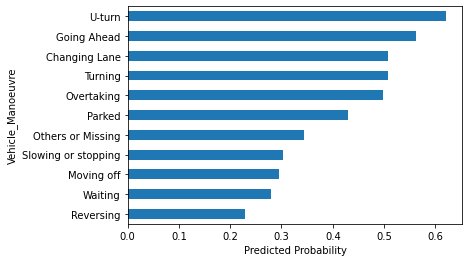

In [0]:
pd.concat([catboost_res_DF, catestX_Shap], axis = 1).groupby("Vehicle_Manoeuvre")[1].agg("mean").sort_values().plot.barh()
plt.xlabel("Predicted Probability")
plt.savefig('Vehicle_Manoeuvre.png', dpi=300)
plt.show()
files.download("Vehicle_Manoeuvre.png") 

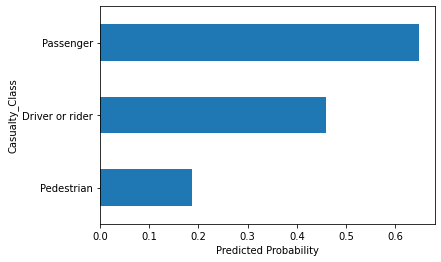

In [0]:
pd.concat([catboost_res_DF, catestX_Shap], axis = 1).groupby("Casualty_Class")[1].agg("mean").sort_values().plot.barh()
plt.xlabel("Predicted Probability")
plt.savefig('Casualty_Class.png', dpi=300)
plt.show()
files.download("Casualty_Class.png") 

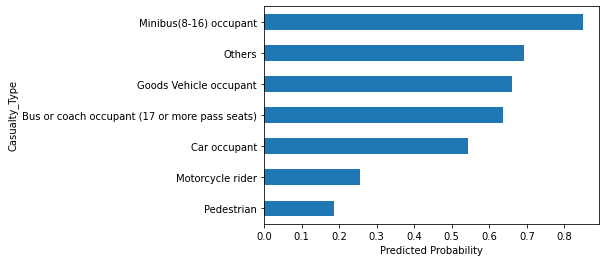

In [0]:
pd.concat([catboost_res_DF, catestX_Shap], axis = 1).groupby("Casualty_Type")[1].agg("mean").sort_values().plot.barh()
plt.xlabel("Predicted Probability")
plt.savefig('Casualty_Type.png', dpi=300)
plt.show()
files.download("Casualty_Type.png") 

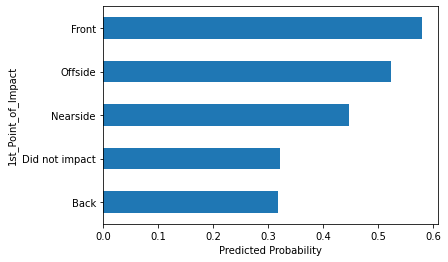

In [0]:
pd.concat([catboost_res_DF, catestX_Shap], axis = 1).groupby("1st_Point_of_Impact")[1].agg("mean").sort_values().plot.barh()
plt.xlabel("Predicted Probability")
plt.savefig('FirstImpact.png', dpi=300)
plt.show()
files.download("FirstImpact.png") 